In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()



In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [15]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt = DecisionTreeClassifier(max_depth=20,random_state=42)
dt.fit(x_train, y_train) 

y_pred = dt.predict(x_test)

Accuracy on the test set: 0.684789644012945
              precision    recall  f1-score   support

           0       0.25      0.35      0.29        60
           1       0.70      0.80      0.75       720
           2       0.74      0.75      0.74       750
           3       0.69      0.68      0.68       450
           4       0.74      0.71      0.72       660
           5       0.53      0.48      0.50        60
           6       0.42      0.37      0.39        90
           7       0.44      0.33      0.38        60
           8       0.56      0.41      0.48       150
           9       0.65      0.51      0.57        90

    accuracy                           0.68      3090
   macro avg       0.57      0.54      0.55      3090
weighted avg       0.68      0.68      0.68      3090



In [17]:
dt.tree_.max_depth

20

In [18]:
calculate_metrics_and_mean(x_test, y_test, y_pred, dt)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.250000,0.350000,0.291667,0.350000,0.020792,0.979208,0.350000,0.745568,0.68479,0.827832,0.022177
1,0.700489,0.795833,0.745124,0.795833,0.103376,0.896624,0.795833,0.745568,NaN,NaN,NaN
2,0.740106,0.748000,0.744032,0.748000,0.084188,0.915812,0.748000,0.745568,NaN,NaN,NaN
3,0.686937,0.677778,0.682327,0.677778,0.052652,0.947348,0.677778,0.745568,NaN,NaN,NaN
4,0.743222,0.706061,0.724165,0.706061,0.066255,0.933745,0.706061,0.745568,NaN,NaN,NaN
5,0.527273,0.483333,0.504348,0.483333,0.008581,0.991419,0.483333,0.745568,NaN,NaN,NaN
6,0.423077,0.366667,0.392857,0.366667,0.015000,0.985000,0.366667,0.745568,NaN,NaN,NaN
7,0.444444,0.333333,0.380952,0.333333,0.008251,0.991749,0.333333,0.745568,NaN,NaN,NaN
8,0.563636,0.413333,0.476923,0.413333,0.016327,0.983673,0.413333,0.745568,NaN,NaN,NaN
9,0.647887,0.511111,0.571429,0.511111,0.008333,0.991667,0.511111,0.745568,NaN,NaN,NaN


[Text(0.3813591231772832, 0.9761904761904762, 'x[1264] <= 84.5\ngini = 0.824\nsamples = 9690\nvalue = [210, 2220, 2250, 1410, 1980, 210, 360, 240, 540, 270]'),
 Text(0.16302897759976975, 0.9285714285714286, 'x[983] <= 38.5\ngini = 0.828\nsamples = 4098\nvalue = [11, 336, 451, 1183, 931, 149, 338, 168, 321, 210]'),
 Text(0.03555257099002302, 0.8809523809523809, 'x[1170] <= 22.5\ngini = 0.564\nsamples = 1102\nvalue = [0, 43, 64, 226, 686, 30, 34, 13, 6, 0]'),
 Text(0.00844205679201842, 0.8333333333333334, 'x[982] <= 13.5\ngini = 0.64\nsamples = 333\nvalue = [0, 7, 11, 178, 81, 30, 25, 0, 1, 0]'),
 Text(0.0059861857252494245, 0.7857142857142857, 'x[663] <= 6.0\ngini = 0.028\nsamples = 70\nvalue = [0, 0, 0, 0, 69, 1, 0, 0, 0, 0]'),
 Text(0.004758250191864927, 0.7380952380952381, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]'),
 Text(0.007214121258633922, 0.7380952380952381, 'gini = 0.0\nsamples = 69\nvalue = [0, 0, 0, 0, 69, 0, 0, 0, 0, 0]'),
 Text(0.010897927858787414, 

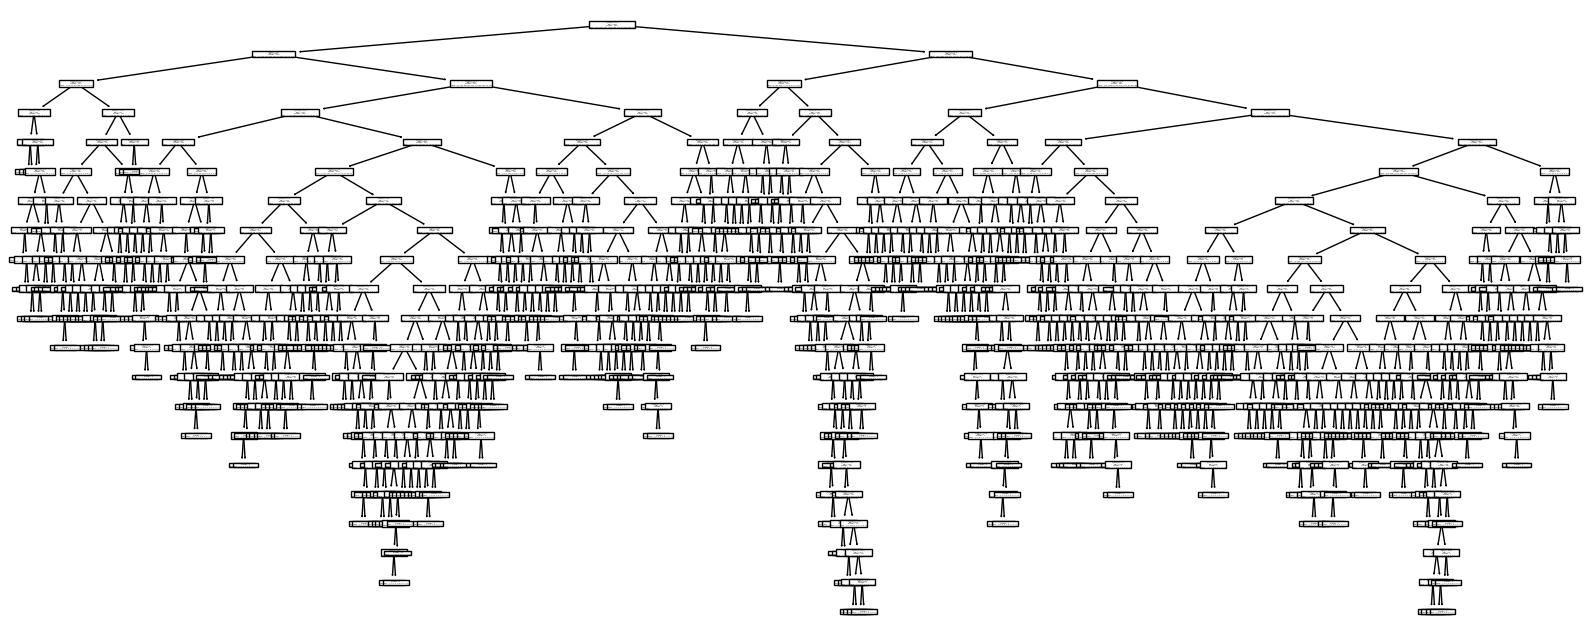

In [19]:
plt.figure(figsize=(20, 8))
plot_tree(dt)